In [1]:
import re
import os
from pypdf import PdfReader

def extract_cleaned_pdf(pdf_path):
    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"Check your path! No file found at: {pdf_path}")

    reader = PdfReader(pdf_path)
    pages = []
    
    for i, page in enumerate(reader.pages):
        try:
            text = page.extract_text()
            if text:
                # 1. Remove Page Numbers (matches "Page 1", "Page 1 of 10", etc.)
                text = re.sub(r'(?i)page\s*\d+(\s*of\s*\d+)?', '', text)
                
                # 2. Normalize whitespace but keep single newlines for structure
                text = re.sub(r'[ \t]+', ' ', text)  # Collapse horizontal tabs/spaces
                text = re.sub(r'\n\s*\n', '\n', text) # Collapse multiple newlines
                
                pages.append(text.strip())
        except Exception as e:
            print(f"Error reading page {i}: {e}")
            
    return pages

# Usage
pdf_path = r"C:\Users\Gopi\Desktop\AI Chatbot\Quikjet_hr_policies\Quikjet_hr_policies.pdf"
raw_pages = extract_cleaned_pdf(pdf_path)

print(f"Successfully extracted {len(raw_pages)} pages.")

Successfully extracted 488 pages.


In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,   # ~800–1000 tokens
    chunk_overlap=250, # overlap to preserve context
    separators=["\n\n", "\n", ".", " "] # split by paragraphs/sentences
)

docs = text_splitter.create_documents(raw_pages)


all_docs = []
for i, page_text in enumerate(raw_pages):
    chunks = text_splitter.split_text(page_text)
    for chunk in chunks:
        # Creating Document objects ensures compatibility with LangChain Vector Stores
        new_doc = Document(
            page_content=chunk,
            metadata={"source": "Quikjet_hr_policies.pdf", "page": i + 1}
        )
        all_docs.append(new_doc)

print(f"Total Document Objects created: {len(all_docs)}")

c:\Users\Gopi\Desktop\AI Chatbot\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Gopi\Desktop\AI Chatbot\myenv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):



Total Document Objects created: 1666


In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
import os

# 1. Setup Hugging Face Embeddings (Runs locally on your CPU/GPU)
# This turns your text chunks into numbers (vectors)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-l6-v2")

# 2. Setup Google Gemini (The Brain)

google_api_key=os.getenv("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    temperature=0.0, # Low temperature is better for factual HR policies
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

print("Models initialized successfully.")

Models initialized successfully.


In [ ]:
from langchain_chroma import Chroma

# Convert your 'docs' (Document objects) into a searchable database
vectorstore = Chroma.from_documents(
    documents=all_docs, # These are the Document objects we created earlier
    embedding=embedding_model,
    persist_directory="./chroma_db" # This saves the DB to your disk
)

# Create a 'Retriever' to find relevant chunks
retriever = vectorstore.as_retriever(search_kwargs={"k": 10}) 

print("Vector Database created and saved locally.")

Vector Database created and saved locally.


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# 1. Define the System Prompt (The instructions for Gemini)
# We tell it to look for the [Source: Page X] tags we will inject
system_prompt = (
    "You are an expert HR Assistant for Quikjet Airlines. "
    "Use the following pieces of retrieved context (which include [Source: Page X] markers) "
    "to answer the user's question accurately. "
    "\n\n"
    "If the answer is found in a table or annexure, describe it clearly. "
    "If the context does not contain the specific answer, state that you don't know "
    "based on the provided pages, but mention if the context points to another section "
    "(e.g., 'Refer to the Appointment Letter')."
    "\n\n"
    "Context: {context}"
)

# 2. Build the Prompt Template
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

# 3. Helper Function: Formats chunks to include page numbers in the text
def format_docs_with_sources(docs):
    context_parts = []
    for doc in docs:
        page_num = doc.metadata.get("page", "Unknown")
        content = f"[Source: Page {page_num}]\n{doc.page_content}"
        context_parts.append(content)
    return "\n\n---\n\n".join(context_parts)

# 4. The Main Execution Function
def generate_answer(query):
    # A. Retrieve relevant chunks (using the retriever defined in Cell 4)
    # We use itemgetter to ensure the retriever gets a string, not a dict
    docs = (itemgetter("input") | retriever).invoke({"input": query})
    
    # B. Format those chunks into one string with source tags
    formatted_context = format_docs_with_sources(docs)
    
    # C. Build the chain for this specific query
    # We pass the context and the query into the prompt
    chain = prompt | llm | StrOutputParser()
    
    # D. Get the response from Gemini
    response = chain.invoke({"context": formatted_context, "input": query})
    
    # E. Extract page numbers for the final verification display
    page_list = sorted(list(set([str(doc.metadata.get("page")) for doc in docs])))
    
    return {
        "answer": response,
        "sources": f"Information retrieved from pages: {', '.join(page_list)}"
    }

# --- RUN A TEST ---
user_query = "What are the rules regarding Sick Leave?"
result = generate_answer(user_query)

print(f"QUESTION: {user_query}\n")
print(f"ANSWER: {result['answer']}\n")
print(f"VERIFICATION: {result['sources']}")

QUESTION: What are the rules regarding Sick Leave?

ANSWER: Here are the rules regarding Sick Leave (SL) at Quikjet Airlines:

**1. Entitlement and Accrual:**
*   Employees are entitled to 12 days of combined Casual Leave (CL) and Sick Leave (SL) per year. [Source: Page 425]
*   These 12 days are credited at a rate of 1 day at the beginning of each month. Employees can use these days as either CL or SL. [Source: Page 425]
*   A minimum of 15 days of attendance is required to measure one month for leave calculation; any shortfall will result in prorated leave. [Source: Page 424]

**2. Eligibility:**
*   All employees, including those under probation, are eligible for CL/SL. [Source: Page 425]

**3. Usage and Duration:**
*   CL/SL cannot be availed for more than 2 days at a stretch. [Source: Page 425]
*   If sick leave is taken for more than 2 days, a medical certificate from a qualified medical practitioner must be submitted to the HR department. [Source: Page 426]
*   For longer durati

In [ ]:

import pandas as pd

# 1. Define your list of test questions
queries = [
    "What is the duration of the probation period for new employees?",
    "What are the specific rules regarding Sick Leave and Casual Leave?",
    "Does the manual mention policies regarding sexual harassment or POSH?",
    "What is the notice period required for resignation?",
    "What are the rules for Cockpit Crew declared Temporarily Medically Unfit (TMU)?"
]

# 2. Create an empty list to store results
results_list = []

print("Starting Batch Test... Please wait.")

# 3. Loop through each question
for q in queries:
    print(f"Processing: {q}")
    output = generate_answer(q) # This calls the function we just made
    
    # Add the question and the AI's response to our list
    results_list.append({
        "Question": q,
        "AI_Answer": output["answer"],
        "Source_Pages": output["sources"]
    })

# 4. Convert the list into a DataFrame (Table)
df = pd.DataFrame(results_list)

# 5. Save it to a CSV file on your computer
df.to_csv("Quikjet_HR_Test_Results.csv", index=False)

print("\nSuccess! Results saved to 'Quikjet_HR_Test_Results.csv'")
# Display the first few rows in your notebook
df.head()

Starting Batch Test... Please wait.
Processing: What is the duration of the probation period for new employees?


ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 25.781779841s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash', 'location': 'global'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '25s'}]}}

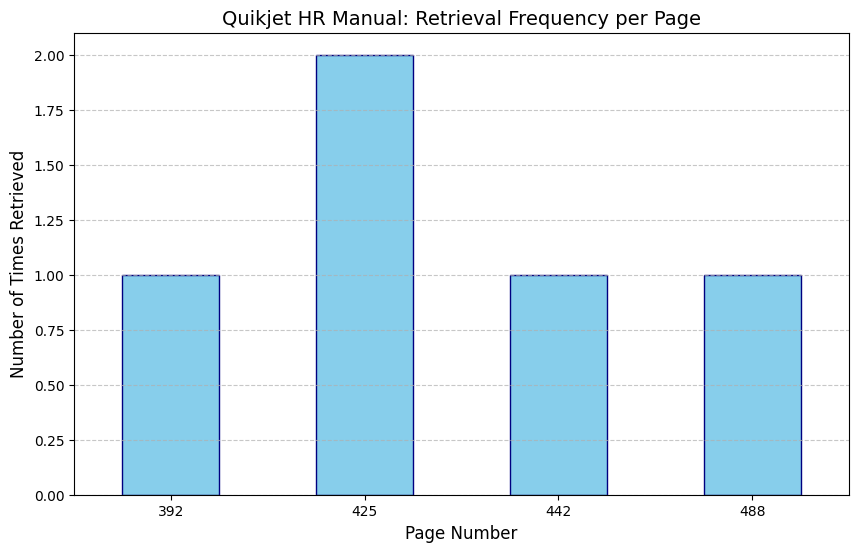

In [ ]:
import matplotlib.pyplot as plt

# 1. Extract all page numbers from your previous results
all_retrieved_pages = []
for result in results_list:
    # Extract numbers from the string "Information retrieved from pages: 425, 442..."
    pages_str = result["Source_Pages"].replace("Information retrieved from pages: ", "")
    page_numbers = [p.strip() for p in pages_str.split(",")]
    all_retrieved_pages.extend(page_numbers)

# 2. Count how many times each page appeared
page_counts = pd.Series(all_retrieved_pages).value_counts().sort_index()

# 3. Create the Visualization
plt.figure(figsize=(10, 6))
page_counts.plot(kind='bar', color='skyblue', edgecolor='navy')

plt.title('Quikjet HR Manual: Retrieval Frequency per Page', fontsize=14)
plt.xlabel('Page Number', fontsize=12)
plt.ylabel('Number of Times Retrieved', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.show()